# Compare GPs + Plot

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1 
f_smooth = lambda x: 15*(x[:,0]-1/2)**2*torch.sin(2*torch.pi*x[:,0])
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
f = f_smooth
def fp(x):
    xg = x.clone().requires_grad_(True)
    yg = f(xg)
    yp = torch.autograd.grad(yg,xg,grad_outputs=torch.ones_like(yg))[0]
    return yp[:,0].detach()

In [5]:
xticks = torch.linspace(0,1,252)[1:-1,None]
yticks = f(xticks)
ypticks = fp(xticks)
print("xticks.shape = %s"%str(tuple(xticks.shape)))
print("yticks.shape = %s"%str(tuple(yticks.shape)))
print("ypticks.shape = %s"%str(tuple(ypticks.shape)))

xticks.shape = (250, 1)
yticks.shape = (250,)
ypticks.shape = (250,)


## Fast GP Construction

In [6]:
gps = [
    fastgps.StandardGP(seqs=qp.DigitalNetB2(1,seed=11,randomize="DS"),gaussian_kernel_use_dist_func=False),
    fastgps.FastGPDigitalNetB2(seqs=qp.DigitalNetB2(1,seed=7,randomize="DS"),alpha=4),
    fastgps.FastGPLattice(seqs=qp.Lattice(1,seed=7),alpha=4),
]

In [7]:
gps_grad = [
    fastgps.StandardGP(
        seqs = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=11,randomize="DS")],
        num_tasks = 2,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
        gaussian_kernel_use_dist_func = False,
    ),
    fastgps.FastGPDigitalNetB2(
        seqs = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=11,randomize="DS")],
        num_tasks = 2,
        alpha = 4,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
    ),
    fastgps.FastGPLattice(
        seqs = [qp.Lattice(1,seed=7),qp.Lattice(1,seed=11)],
        num_tasks = 2,
        alpha = 4,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
    ),
]

## GP Fitting

In [8]:
pmeans = [None]*len(gps)
pci_lows = [None]*len(gps)
pci_highs = [None]*len(gps)
for i,gp in enumerate(gps):
    print(type(gp).__name__)
    x_next = gp.get_x_next(n=2**2)
    gp.add_y_next(f(x_next))
    gp.fit()
    pmeans[i],_,_,pci_lows[i],pci_highs[i] = gp.post_ci(xticks,confidence=0.95)
    print("\tl2 relative error = %.1e"%(torch.linalg.norm(yticks-pmeans[i])/torch.linalg.norm(yticks)))


StandardGP
     iter of 5.0e+03 | best loss  | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.88e+02   | 4.88e+02   | 9.81e+02   | -1.36e+01 
            5.00e+00 | 8.89e+00   | 8.89e+00   | 1.40e+01   | -3.56e+00 
            1.00e+01 | 4.62e+00   | 4.62e+00   | 2.93e+00   | -1.04e+00 
            1.50e+01 | 3.95e+00   | 3.96e+00   | 3.58e+00   | -3.01e+00 
            2.00e+01 | 3.94e+00   | 3.95e+00   | 3.60e+00   | -3.04e+00 
            2.40e+01 | 3.94e+00   | 3.94e+00   | 4.02e+00   | -3.48e+00 
	l2 relative error = 5.5e-01
FastGPDigitalNetB2
     iter of 5.0e+03 | best loss  | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.62e+00   | 5.62e+00   | 1.55e+00   | 2.35e+00  
            5.00e+00 | 5.08e+00   | 5.08e+00   | 4.37e+00   | -1.56e+00 
            1.00e+01 | 4.99e+00   | 4.99e+00   | 3.43e+00   | -7.

In [9]:
pmeans_grad = [None]*len(gps_grad)
pci_lows_grad = [None]*len(gps_grad)
pci_highs_grad = [None]*len(gps_grad)
for i,gp in enumerate(gps_grad):
    print(type(gp).__name__)
    x_next = gp.get_x_next(n=[2**2,2**2])
    gp.add_y_next([f(x_next[0]),fp(x_next[1])])
    gp.fit()
    pmeans_grad[i],_,_,pci_lows_grad[i],pci_highs_grad[i] = gp.post_ci(xticks,confidence=0.95)
    print("\tl2 relative error = %.1e"%(torch.linalg.norm(yticks-pmeans_grad[i][0])/torch.linalg.norm(yticks)))

StandardGP
     iter of 5.0e+03 | best loss  | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.04e+05   | 2.04e+05   | 4.09e+05   | -3.73e+01 
            5.00e+00 | 1.03e+03   | 1.03e+03   | 2.07e+03   | -1.92e+01 
            1.00e+01 | 1.99e+01   | 2.17e+01   | 1.85e+01   | 1.03e+01  
            1.50e+01 | 1.99e+01   | 1.99e+01   | 8.60e+00   | 1.65e+01  
            1.80e+01 | 1.99e+01   | 1.99e+01   | 7.50e+00   | 1.75e+01  
	l2 relative error = 2.2e-01
FastGPDigitalNetB2
     iter of 5.0e+03 | best loss  | loss       | term1      | term2     
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.74e+02   | 2.74e+02   | 5.28e+02   | 4.80e+00  
            5.00e+00 | 1.22e+02   | 1.22e+02   | 2.18e+02   | 1.09e+01  
            1.00e+01 | 3.70e+01   | 3.70e+01   | 3.38e+01   | 2.55e+01  
            1.50e+01 | 2.68e+01   | 2.68e+01   | 1.34e+00   | 3.7

## Plot

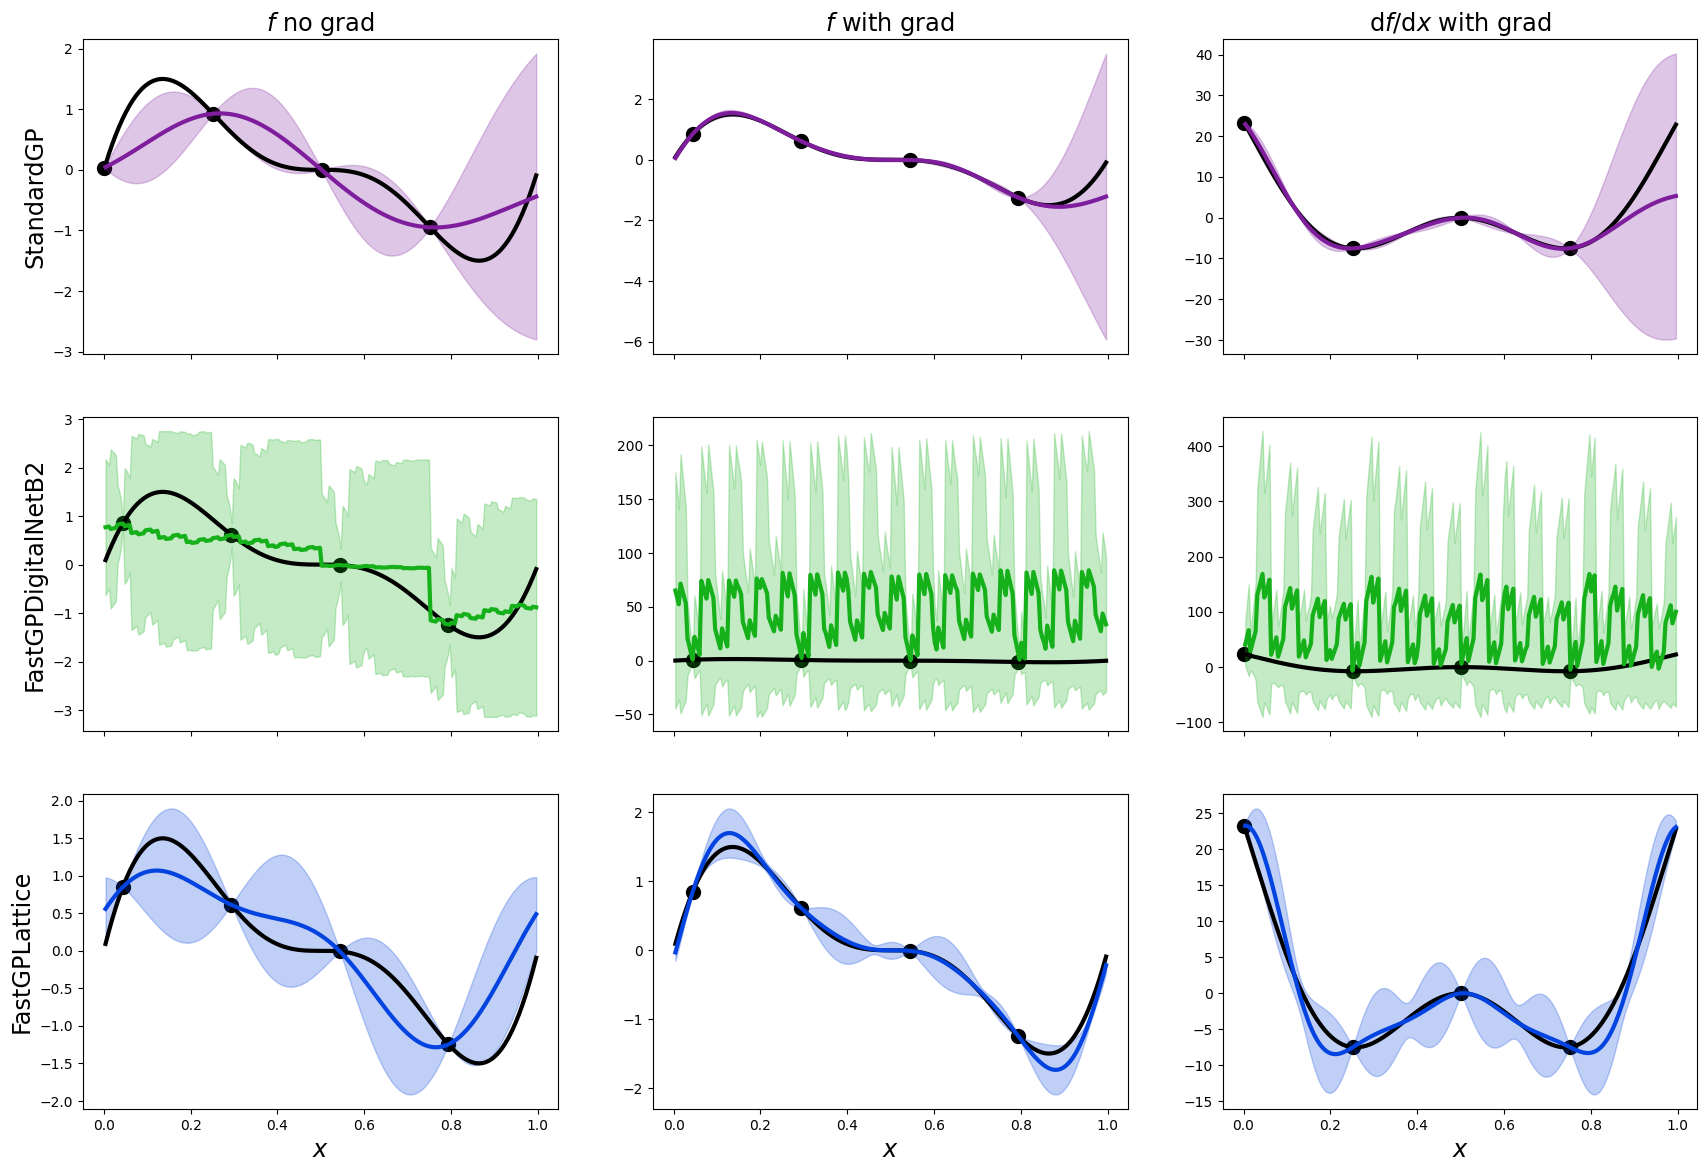

In [10]:
fig,ax = pyplot.subplots(nrows=len(gps),ncols=3,sharex=True,sharey=False,figsize=(WIDTH*1.5,WIDTH/len(gps)*3))
ax = ax.reshape((len(gps),3))
for i,gp in enumerate(gps):
    ax[i,0].set_ylabel(type(gp).__name__,fontsize="xx-large")
    ax[i,0].plot(xticks[:,0],yticks,color="k",linewidth=LINEWIDTH)
    ax[i,0].scatter(gp.x[:,0],gp.y,color="k",s=MARKERSIZE)
    ax[i,0].plot(xticks[:,0],pmeans[i],color=colors[i],linewidth=LINEWIDTH)
    ax[i,0].fill_between(xticks[:,0],pci_lows[i],pci_highs[i],color=colors[i],alpha=_alpha)
for i,gp in enumerate(gps_grad):
    ax[i,1].plot(xticks[:,0],yticks,color="k",linewidth=LINEWIDTH)
    ax[i,2].plot(xticks[:,0],ypticks,color="k",linewidth=LINEWIDTH)
    ax[i,1].scatter(gp.x[0][:,0],gp.y[0],color="k",s=MARKERSIZE)
    ax[i,2].scatter(gp.x[1][:,0],gp.y[1],color="k",s=MARKERSIZE)
    ax[i,1].plot(xticks[:,0],pmeans_grad[i][0],color=colors[i],linewidth=LINEWIDTH)
    ax[i,2].plot(xticks[:,0],pmeans_grad[i][1],color=colors[i],linewidth=LINEWIDTH)
    ax[i,1].fill_between(xticks[:,0],pci_lows_grad[i][0],pci_highs_grad[i][0],color=colors[i],alpha=_alpha)
    ax[i,2].fill_between(xticks[:,0],pci_lows_grad[i][1],pci_highs_grad[i][1],color=colors[i],alpha=_alpha)
ax[0,0].set_title(r"$f$ no grad",fontsize="xx-large")
ax[0,1].set_title(r"$f$ with grad",fontsize="xx-large")
ax[0,2].set_title(r"$\mathrm{d} f / \mathrm{d} x$ with grad",fontsize="xx-large")
for j in range(3):
    ax[-1,j].set_xlabel(r"$x$",fontsize="xx-large")
fig.savefig("./gps_deriv.pdf",bbox_inches="tight")